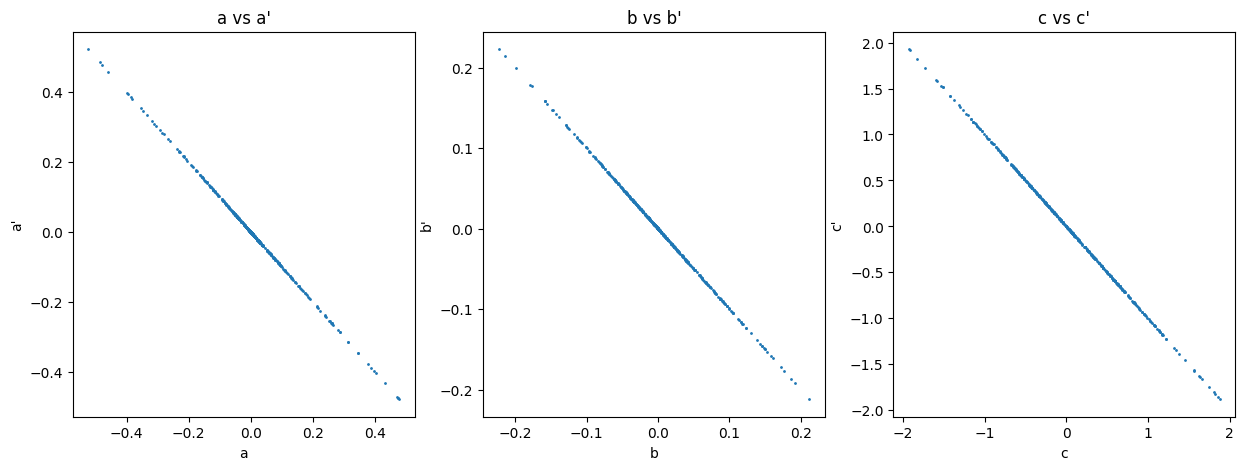

In [17]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import SwapGate, CXGate
from qiskit.quantum_info import random_unitary
from weylchamber import c1c2c3, g1g2g3
import matplotlib.pyplot as plt

N = 500
# generate (a,b,c) ->swap-> (a',b',c') pairs
a_pairs, b_pairs, c_pairs = [], [], []
for _ in range(N):
    U = random_unitary(4).data
    U_prime = SwapGate().to_matrix() @ U
    abc = g1g2g3(U)
    abc_prime = g1g2g3(U_prime)
    a_pairs.append((abc[0], abc_prime[0]))
    b_pairs.append((abc[1], abc_prime[1]))
    c_pairs.append((abc[2], abc_prime[2]))
# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (pairs, label) in enumerate(zip([a_pairs, b_pairs, c_pairs], ["a", "b", "c"])):
    axes[i].scatter(*zip(*pairs), s=1)
    axes[i].set_xlabel(f"{label}")
    axes[i].set_ylabel(f"{label}'")
    axes[i].set_title(f"{label} vs {label}'")
plt.show()

In [10]:
print(pairs)

[((0.52936061, 0.23718652, 0.08374502), (0.41625498, 0.26281348, 0.02936061)), ((0.30635241, 0.28050738, 0.06389685), (0.56389685, 0.21949262, 0.19364759)), ((0.67994194, 0.20374179, 0.05724807), (0.44275193, 0.29625821, 0.17994194)), ((0.58645234, 0.20723262, 0.10180771), (0.39819229, 0.29276738, 0.08645234)), ((0.3676235, 0.18349775, 0.11004043), (0.61004043, 0.31650225, 0.1323765)), ((0.55303297, 0.14917981, 0.09199502), (0.40800498, 0.35082019, 0.05303297)), ((0.57785537, 0.2402563, 0.0197865), (0.4802135, 0.2597437, 0.07785537)), ((0.52913571, 0.18110145, 0.1489612), (0.3510388, 0.31889855, 0.02913571)), ((0.66446287, 0.13035973, 0.05820839), (0.44179161, 0.36964027, 0.16446287)), ((0.38514208, 0.08150909, 0.05579764), (0.55579764, 0.41849091, 0.11485792)), ((0.42850748, 0.17030732, 0.11262697), (0.61262697, 0.32969268, 0.07149252)), ((0.51720775, 0.25570409, 0.15452727), (0.34547273, 0.24429591, 0.01720775)), ((0.63098035, 0.28112701, 0.06376932), (0.43623068, 0.21887299, 0.13098

In [13]:
# fit function to data describing transformation from abc to abc_prime
from scipy.optimize import curve_fit
import numpy as np

[-94.3458405  238.17566556 -33.12548449] [[ 3.37692620e+51 -5.39009374e+51 -2.00522291e+50]
 [-5.39009374e+51  8.60341886e+51  3.20064426e+50]
 [-2.00522291e+50  3.20064426e+50  1.19070382e+49]]
